In [26]:
import os
from typing import Tuple, Optional, Iterable, List
import torch
from torch import Tensor
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader     
from tqdm.notebook import tqdm

import pytorch_lightning as pl

In [29]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in tqdm(dataloader):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [30]:
defualt_transforms = T.Compose([T.Resize((224,224)),
                                T.RandomApply([T.RandomRotation(degrees=(10)), 
                                               T.RandomAffine(degrees=0, shear=10, scale=(1,1))], p=0.5),
                                T.RandomHorizontalFlip(p=0.5),
                                T.ToTensor(),
                                T.Normalize(mean=torch.tensor([0.1115]), 
                                            std=torch.tensor([0.1372])),
                        ])

specific_transforms = T.Compose([T.Resize((224,224)),
                                T.ToTensor(),
                                T.Normalize(mean=torch.tensor([0.1115]),
                                            std=torch.tensor([0.1372])), 
                        ])

In [36]:
stat_transforms = T.Compose([T.Resize((512,512)),
                             T.ToTensor(), 
                        ])

In [37]:
class StatData(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 transforms: Optional[T.Compose] = None
                ) -> None:
        
        self.transforms = transforms
        self.all_images = self._get_all_images(data_dir)

        if self.transforms is None:
            self.transforms = defualt_transforms
            

    def __getitem__(self, 
                    idx: int
                   ) -> Tuple[Tensor]:
        
        image = self.all_images[idx]
        view1 = self.transforms(Image.open(fp=image))
        return view1
        
        
    def __len__(self) -> int:
        return len(self.all_images)
    
    
    def _get_all_images(self, 
                        data_dir
                       ) -> List[List[str]]:
        
        all_images = []
        patients = os.listdir(data_dir)
        
        for patient in patients:
            sessions = os.listdir(os.path.join(data_dir,patient))
            
            for session in sessions:
                eye_directions = os.listdir(os.path.join(data_dir,patient,session))
                
                for direction in eye_directions:
                    images =  os.listdir(os.path.join(data_dir,patient,session,direction))
                    
                    for image in images:
                        all_images.append(os.path.join(data_dir,patient,session,direction,image)) 
        
        return all_images

In [38]:
oct_path = os.path.join('..','data','pretext')
dataset = StatData(oct_path,stat_transforms)

In [39]:
train = DataLoader(dataset,batch_size=1)

In [40]:
get_mean_and_std(train)

  0%|          | 0/3748 [00:00<?, ?it/s]

(tensor([0.1117]), tensor([0.1279]))

In [36]:
class UnrestrictedOCT(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 transforms: Optional[T.Compose] = None
                ) -> None:
        
        self.transforms = transforms
        self.all_images = self._get_all_images(data_dir)

        if self.transforms is None:
            self.transforms = defualt_transforms
            

    def __getitem__(self, 
                    idx: int
                   ) -> Tuple[Tensor]:
        
        image = self.all_images[idx]
        view1 = self.transforms(Image.open(fp=image))
        view2 = self.transforms(Image.open(fp=image))
        return (view1, view2)
        
        
    def __len__(self) -> int:
        return len(self.all_images)
    
    
    def _get_all_images(self, 
                        data_dir
                       ) -> List[List[str]]:
        
        all_images = []
        patients = os.listdir(data_dir)
        
        for patient in patients:
            sessions = os.listdir(os.path.join(data_dir,patient))
            
            for session in sessions:
                eye_directions = os.listdir(os.path.join(data_dir,patient,session))
                
                for direction in eye_directions:
                    images =  os.listdir(os.path.join(data_dir,patient,session,direction))
                    
                    for image in images:
                        all_images.append(os.path.join(data_dir,patient,session,direction,image)) 
        
        return all_images

In [37]:
oct_path = os.path.join('..','data','pretext')
oct_path

'../data/pretext'

In [38]:
dataset = UnrestrictedOCT(data_dir = oct_path)

In [39]:
train = DataLoader(dataset,batch_size=1)


In [40]:
x,y = next(iter(train))

In [41]:
x

tensor([[[[-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127],
          [-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127],
          [-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127],
          ...,
          [-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127],
          [-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127],
          [-0.8127, -0.8127, -0.8127,  ..., -0.8127, -0.8127, -0.8127]]]])

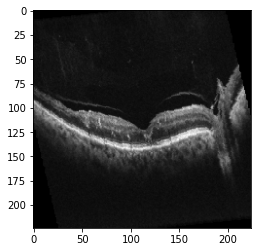

In [42]:
plt.imshow(x.squeeze(0).permute((1,2,0)),cmap='gray')

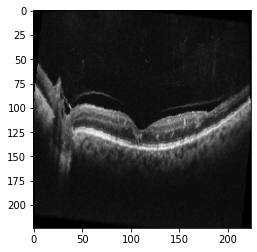

In [43]:
plt.imshow(y.squeeze(0).permute((1,2,0)),cmap='gray')

In [44]:
class UnristrictedDataLoader(pl.LightningDataModule): 
    def __init__(self,
                data_dir: str,
                transforms: Optional[T.Compose] = None,
                batch_size: int = 128
                ) -> None:
        super(UnristrictedDataLoader, self).__init__()
        
        self.data_dir = data_dir
        self.transforms = transforms
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None):
        self.train_dataset = UnrestrictedOCT(data_dir=self.data_dir, transforms=self.transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True)

In [45]:
train = UnristrictedDataLoader(data_dir=oct_path,transforms=None, batch_size=128 )
train.setup()
train.train_dataloader()

In [48]:
x, y = next(iter(train.train_dataloader()))

In [49]:
class XYRetinaOCT(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 transforms: Optional[T.Compose] = None
                ) -> None:
        self.data_dir = data_dir
        self.transforms = transforms
        self.all_pairs = self._get_all_pairs(data_dir)
        
        
        if self.transforms is None:
            self.transforms = specific_transforms


    def __getitem__(self, idx: int) -> Tuple[Tensor]:
        view1, view2 = self.all_pairs[idx]
        view1 = self.transforms(Image.open(fp=view1))
        view2 = self.transforms(Image.open(fp=view2))
        return (view1, view2)
        
        
    def __len__(self) -> int:
        return len(self.all_pairs)
    
    
    def _get_all_pairs(self, 
                       data_dir: str
                      ) -> List[List[str]]:
        
        all_pairs = []
        patients = os.listdir(data_dir)
        
        for patient in patients:
            sessions = os.listdir(os.path.join(data_dir,patient))
            
            for session in sessions:
                eye_directions = os.listdir(os.path.join(data_dir,patient,session))
                
                for direction in eye_directions:
                    images =  os.listdir(os.path.join(data_dir,patient,session,direction))
                    temp_pairs = []
                    
                    if len(images) == 2:
                        for image in images:
                            temp_pairs.append(os.path.join(data_dir,patient,session,direction,image))
                        all_pairs.append(temp_pairs)
                        
                    elif len(images) < 2:
                        continue
                        
                    elif len(images) > 2 and len(images) %2 == 0:
                        x ,y = [],[]
                        for image in images:
                            x.append(image) if image.endswith('x.bmp') else y.append(image)
                            
                        x.sort()
                        y.sort()
                        
                        for img1, img2 in zip(x,y):
                            temp = [os.path.join(data_dir,patient,session,direction,img1),
                                    os.path.join(data_dir,patient,session,direction,img2)]
                            all_pairs.append(temp)      
        return all_pairs

In [50]:
dataset = XYRetinaOCT(data_dir = oct_path)

In [51]:
train = DataLoader(dataset,batch_size=1)

In [52]:
x,y = next(iter(train))

In [53]:
train.__len__()

1874

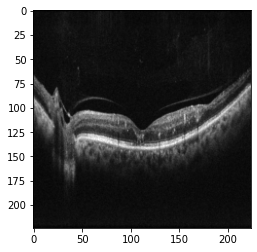

In [54]:
plt.imshow(x.squeeze(0).permute((1,2,0)),cmap='gray')

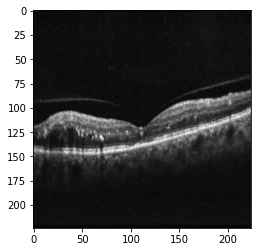

In [55]:
plt.imshow(y.squeeze(0).permute((1,2,0)),cmap='gray')

In [56]:
class XYRetinaDataLoader(pl.LightningDataModule): 
    def __init__(self,
                data_dir: str,
                transforms: Optional[T.Compose] = None,
                batch_size: int = 128
                ) -> None:
        super(XYRetinaDataLoader, self).__init__()
        
        self.data_dir = data_dir
        self.transforms = transforms
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None):
        self.train_dataset = XYRetinaOCT(data_dir=self.data_dir, transforms=self.transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True)

In [57]:
train = XYRetinaDataLoader(data_dir=oct_path,transforms=None, batch_size=128 )
train.setup()
train.train_dataloader()

In [59]:
x, y = next(iter(train.train_dataloader()))

In [25]:
pairs = []
patients = os.listdir(oct_path)
for patient in patients:
    sessions = os.listdir(os.path.join(oct_path,patient))
    for session in sessions:
        eye_directions = os.listdir(os.path.join(oct_path,patient,session))
        for direction in eye_directions:
            images =  os.listdir(os.path.join(oct_path,patient,session,direction))
            temp_pairs = []
            if len(images) == 2:
                for image in images:
                    temp_pairs.append(os.path.join(oct_path,patient,session,direction,image))
                pairs.append(temp_pairs)
            elif len(images) < 2:
                continue
            elif len(images) > 2 and len(images) %2 == 0:
                x ,y = [],[]
                for image in images:
                    x.append(image) if image.endswith('x.bmp') else y.append(image)
                x.sort()
                y.sort()
                for img1, img2 in zip(x,y):
                    temp = [os.path.join(oct_path,patient,session,direction,img1),
                           os.path.join(oct_path,patient,session,direction,img2)]
                    pairs.append(temp)


In [26]:
len(os.listdir(os.path.join('..','data','pretext','p0','20200831','L')))

0

In [27]:
x = 2
len(pairs)

1874

In [28]:
x = [[1,2],[3,4],[5,6]]
y = [[7,8],[[9,10],[11,12]]]

x.extend(y)
x

[[1, 2], [3, 4], [5, 6], [7, 8], [[9, 10], [11, 12]]]

In [29]:
class ConsicutiveSessionsDataLoader(pl.LightningDataModule): 
    def __init__(self,
                data_dir: str,
                transforms: Optional[T.Compose] = None,
                batch_size: int = 128
                ) -> None:
        super(ConsicutiveSessionsDataLoader, self).__init__()
        
        self.data_dir = data_dir
        self.transforms = transforms
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None):
        self.train_dataset = ConsecutiveSessionsOCT(data_dir=self.data_dir, transforms=self.transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True)

In [113]:
class ConsecutiveSessionsOCT(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 transforms: Optional[T.Compose] = None
                ) -> None:
        
        self.transforms = transforms
        self.all_pairs = self._get_all_pairs(data_dir)
        
        if self.transforms is None:
            self.transforms = specific_transforms

            
    def __getitem__(self, idx: int) -> Tuple[Tensor]:
        view1, view2 = self.all_pairs[idx]
        view1 = self.transforms(Image.open(fp=view1))
        view2 = self.transforms(Image.open(fp=view2))
        return (view1, view2)
        
        
    def __len__(self) -> int:
        return len(self.all_pairs)

    
    def consecutive_pairs_generator(self,
                                    input_list: Iterable
                                    ) -> List[List[int]]:
        input_list.sort()
        output_list = []

        for item in range(len(input_list) - 1): 
            output_list.append([input_list[item],input_list[item + 1]])
        
        return output_list
    
    
    def _get_all_pairs(self, 
                   data_dir: str
                  ) -> List[List[str]]:
        all_pairs = []
        patients = os.listdir(data_dir)
        for patient in patients:        
            sessions = os.listdir(os.path.join(data_dir,patient))

            if len(sessions) <= 1:
                continue
            
            sessions_pairs  = self.consecutive_pairs_generator(sessions)
    
            for session in sessions_pairs:
                session1 = session[0]
                session2 = session[1]
        
                session1_directions = sorted(os.listdir(os.path.join(data_dir,patient,session[0])))
                session2_directions = sorted(os.listdir(os.path.join(data_dir,patient,session[1])))
        
                session1_l = session1_directions[0]
                session1_r = session1_directions[1]
        
                session2_l = session2_directions[0]
                session2_r = session2_directions[1]
        
                session1_l_images = os.listdir(os.path.join(data_dir,patient,session1,session1_l))
                session1_r_images = os.listdir(os.path.join(data_dir,patient,session1,session1_r))

                session2_l_images = os.listdir(os.path.join(data_dir,patient,session2,session2_l))
                session2_r_images = os.listdir(os.path.join(data_dir,patient,session2,session2_r))
        
                for image1 in session1_l_images:
                    for image2 in session2_l_images:
                        if image1.endswith('x.bmp') and image2.endswith('x.bmp'):
                            all_pairs.append([os.path.join(os.path.join(data_dir,patient,
                                                                        session1,session1_l, image1)),
                                              os.path.join(os.path.join(data_dir,patient,
                                                                        session2,session2_l, image2))
                                             ])
                                    
                for image1 in session1_r_images:
                    for image2 in session2_r_images:
                        if image1.endswith('x.bmp') and image2.endswith('x.bmp'):
                            all_pairs.append([os.path.join(os.path.join(data_dir,patient,
                                                                        session1,session1_r, image1)),
                                              os.path.join(os.path.join(data_dir,patient,
                                                                        session2,session2_r, image2))
                                             ])
                        
                for image1 in session1_l_images:
                    for image2 in session2_l_images:
                        if image1.endswith('y.bmp') and image2.endswith('y.bmp'):
                            all_pairs.append([os.path.join(os.path.join(data_dir,patient,
                                                                        session1,session1_l, image1)),
                                              os.path.join(os.path.join(data_dir,patient,
                                                                        session2,session2_l, image2))
                                             ])

                for image1 in session1_r_images:
                    for image2 in session2_r_images:
                        if image1.endswith('y.bmp') and image2.endswith('y.bmp'):
                            all_pairs.append([os.path.join(os.path.join(data_dir,patient,
                                                                        session1,session1_r, image1)),
                                              os.path.join(os.path.join(data_dir,patient,
                                                                        session2,session2_r, image2))
                                             ])
        return all_pairs

In [31]:
dataset = ConsecutiveSessionsOCT(data_dir = oct_path)

NameError: name 'ConsecutiveSessionsOCT' is not defined

In [32]:
train = DataLoader(dataset,batch_size=1)

In [116]:
train.__len__()

2572

In [117]:
x,y = next(iter(train))


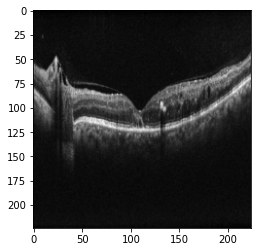

In [118]:
plt.imshow(x.squeeze(0).permute((1,2,0)),cmap='gray')

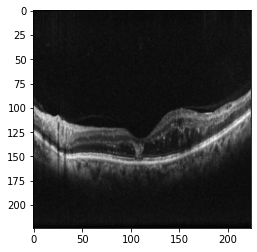

In [119]:
plt.imshow(y.squeeze(0).permute((1,2,0)),cmap='gray')

In [30]:
train = ConsicutiveSessionsDataLoader(data_dir=oct_path,transforms=None, batch_size=128 )
train.setup()
train.train_dataloader()

NameError: name 'ConsicutiveSessionsDataLoader' is not defined

In [29]:
x,y = train.train_dataloader()

ValueError: too many values to unpack (expected 2)

In [31]:
def consecutive_pairs_generator(input_list):
    input_list.sort()
    output_list = []

    for item in range(len(input_list) - 1): 
        output_list.append([input_list[item],input_list[item + 1]])
        
    return output_list

In [32]:
x = [9]
consecutive_pairs_generator(x)

[]

In [33]:

all_pairs = []
patients = os.listdir(oct_path)
for patient in patients:        
    sessions = os.listdir(os.path.join(oct_path,patient))
        
    if len(sessions) <= 1:
        continue
            
    sessions_pairs  = consecutive_pairs_generator(sessions)
    
    for session in sessions_pairs:
        session1 = session[0]
        session2 = session[1]
        
        session1_directions = sorted(os.listdir(os.path.join(oct_path,patient,session[0])))
        session2_directions = sorted(os.listdir(os.path.join(oct_path,patient,session[1])))
        
        session1_l = session1_directions[0]
        session1_r = session1_directions[1]
        
        session2_l = session2_directions[0]
        session2_r = session2_directions[1]
        
        session1_l_images = os.listdir(os.path.join(oct_path,patient,session1,session1_l))
        session1_r_images = os.listdir(os.path.join(oct_path,patient,session1,session1_r))

        session2_l_images = os.listdir(os.path.join(oct_path,patient,session2,session2_l))
        session2_r_images = os.listdir(os.path.join(oct_path,patient,session2,session2_r))
        
        for image1 in session1_l_images:
            for image2 in session2_l_images:
                if image1.endswith('x.bmp') and image2.endswith('x.bmp'):
                    all_pairs.append([os.path.join(os.path.join(oct_path,patient,session1,session1_l, image1)),
                                      os.path.join(os.path.join(oct_path,patient,session2,session2_l, image2))
                                     ])
                                    
        for image1 in session1_r_images:
            for image2 in session2_r_images:
                if image1.endswith('x.bmp') and image2.endswith('x.bmp'):
                    all_pairs.append([os.path.join(os.path.join(oct_path,patient,session1,session1_r, image1)),
                                      os.path.join(os.path.join(oct_path,patient,session2,session2_r, image2))
                                     ])
                        
        for image1 in session1_l_images:
            for image2 in session2_l_images:
                if image1.endswith('y.bmp') and image2.endswith('y.bmp'):
                    all_pairs.append([os.path.join(os.path.join(oct_path,patient,session1,session1_l, image1)),
                                      os.path.join(os.path.join(oct_path,patient,session2,session2_l, image2))
                                     ])

        for image1 in session1_r_images:
            for image2 in session2_r_images:
                if image1.endswith('y.bmp') and image2.endswith('y.bmp'):
                    all_pairs.append([os.path.join(os.path.join(oct_path,patient,session1,session1_r, image1)),
                                      os.path.join(os.path.join(oct_path,patient,session2,session2_r, image2))
                                     ])


['../data/pretext/p134/20190625/L/1197-p134-20190625-L-y.bmp',
 '../data/pretext/p134/20190806/L/1181-p134-20190806-L-y.bmp']

In [169]:
import PIL.Image as Image

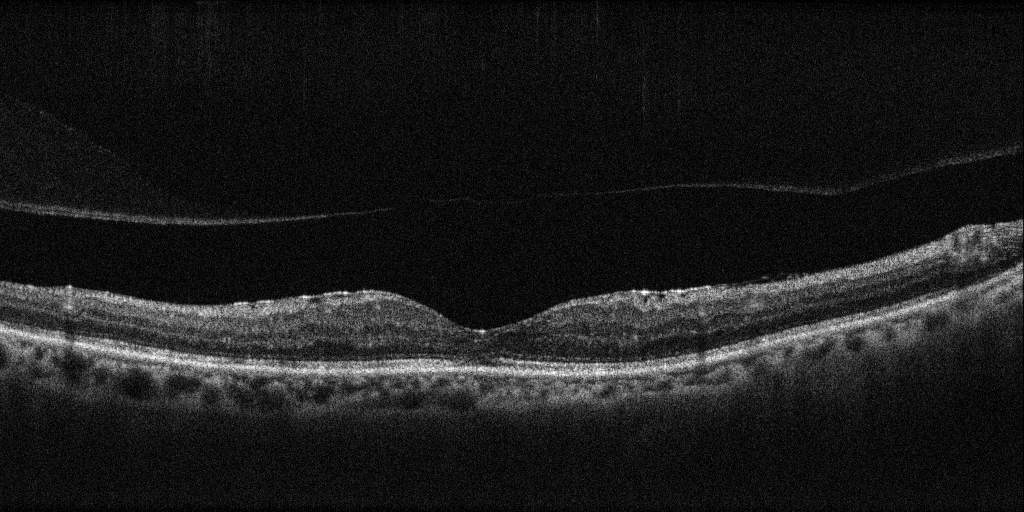

In [189]:
Image.open('../data/pretext/p103/20191128/R/33563-p103-20191128-R-y.bmp')

In [127]:
len(os.listdir(os.path.join('..','data','pretext','p100')))

0

In [89]:
x = [2,1,3]
y = [4,5,6]

for a,b in zip(x,y):
    print(a,b)

2 4
1 5
3 6


In [116]:
x = 'saeed'
x.endswith('ed')

True

In [138]:
import argparse

In [1]:
import os
from typing import Optional, Tuple, List, Iterable
import torch
from torch import Tensor
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl



train_transform = T.Compose([T.Resize((224,224)),
                             T.RandomApply([T.RandomRotation(degrees=(10)), 
                                            T.RandomAffine(degrees=0, shear=10, scale=(1,1))], p=1),
                             T.RandomHorizontalFlip(p=0.5),
                             T.ToTensor(),
                             T.Normalize(mean=torch.tensor([0.1123,0.1123,0.1123]), 
                                         std=torch.tensor([0.1228,0.1228,0.1228])) 
                        ])


val_test_transform = T.Compose([T.Resize((224,224)),
                                T.ToTensor(),
                                T.Normalize(mean=torch.tensor([0.1123,0.1123,0.1123]), 
                                             std=torch.tensor([0.1228,0.1228,0.1228])), 
                        ])


class DownStreamDataModule(pl.LightningDataModule):
    def __init__(self,
                data_dir: str,
                training_transforms: Optional[T.Compose] = None,
                val_test_transforms: Optional[T.Compose] = None,
                batch_size: int = 128,
                num_workers: int = 8,
                pin_memory: bool = True 
                ) -> None:
        super(DownStreamDataModule,self).__init__()
        self.data_dir = data_dir
        self.training_transforms = training_transforms
        self.val_test_transforms = val_test_transforms
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory


        if training_transforms is None:
            self.train_transforms = train_transform

        if val_test_transforms is None:
            self.val_test_transforms = val_test_transform


    def setup(self, stage: Optional[str]):
        self.train_dataset = ImageFolder(root=os.path.join(self.data_dir,'train'), transform=self.training_transforms)
        self.val_dataset = ImageFolder(root=os.path.join(self.data_dir,'val'), transform=self.val_test_transforms)
        self.test_dataset = ImageFolder(root=os.path.join(self.data_dir,'test'), transform=self.val_test_transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers, pin_memory= self.pin_memory,
                         )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers, pin_memory= self.pin_memory
                         )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers, pin_memory= self.pin_memory
                         )

In [2]:
oct_path = os.path.join('..','data','down-stream','grading','MRO')


In [3]:
dataset = DownStreamDataModule(data_dir = oct_path, training_transforms= None, val_test_transforms= None)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:122: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."


In [4]:
train = DataLoader(dataset,batch_size=10)
x, y = next(iter(train))

TypeError: object of type 'DownStreamDataModule' has no len()

In [175]:
dataset = ImageFolder(oct_path,train_transform)

In [176]:
train = DataLoader(dataset,batch_size=1)


In [244]:
next(iter(train))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([0])]

In [178]:
y

tensor([0])

In [131]:
import os
import torch
from torch import Tensor
from torch.utils.data import Dataset
from typing import Dict, Tuple, List
from PIL import Image

In [14]:
train_path = os.path.join('..','data','down-stream','binary','train')
val_path = os.path.join('..','data','down-stream','binary','val')
test_path = os.path.join('..','data','down-stream','binary','test')

In [245]:
class ClassificationDataset(Dataset):
    def __init__(self,
                 data_dir:  str,
                 form: str = 'binary',
                 transform: Optional[T.Compose] = None,
                 ) -> None:
        

        self.data_dir = data_dir
        self.form = form
        self.transform = transform
        self.all_images = self._get_images(self.data_dir)
        
    def __len__(self):
        return len(self.all_images)
    
    
    
    def __getitem__(self,
                    idx: int
                    ) -> Tuple[Tensor,int]:
        
        image = self.all_images[idx]

        print(image)
        if self.form == 'binary':
            label = torch.tensor([0]) if image.split('/')[-2] == 'Normal' else torch.tensor([1])
            image = self.transform(Image.open(image))
        
        elif self.form == 'multi-class':
            if image.split('/')[-2] == 'Normal':
                label = torch.tensor([0])
                image = self.transform(Image.open(image)) 
                
            elif image.split('/')[-2] == 'CNV':
                label = torch.tensor([1])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'CSR':
                label = torch.tensor([2])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'GA':
                label = torch.tensor([3])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'MRO':
                label = torch.tensor([4])
                image = self.transform(Image.open(image))  

            elif image.split('/')[-2] == 'VMT':
                label = torch.tensor([5])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'MH':
                label = torch.tensor([6])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'FMH':
                label = torch.tensor([6])
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'PMH':
                label = torch.tensor([7])
                image = self.transform(Image.open(image))  

                
        elif self.form == 'grading':
            if image.split('/')[-2] == 'mild':
                label = torch.tensor(0)
                image = self.transform(Image.open(image)) 
                
            elif image.split('/')[-2] == 'moderate':
                label = torch.tensor(1)
                image = self.transform(Image.open(image))  
                
            elif image.split('/')[-2] == 'severe':
                label = torch.tensor(2)
                image = self.transform(Image.open(image))
        
        
        return (image,label)
        

        
    
    def _get_images(self,
                    data_dir: str
                   ) -> List[str]: 
    
        labels = os.listdir(data_dir)
        all_images = []
    
        for label in labels:
            images = os.listdir(os.path.join(data_dir,label))
        
            for image in images:
                all_images.append(os.path.join(data_dir,label,image))
    
        return all_images

In [269]:
class DownStreamDataModule(pl.LightningDataModule):
    def __init__(self,
                 data_dir: str,
                 form:str = 'grading',
                 training_transforms: Optional[T.Compose] = None,
                 val_test_transforms: Optional[T.Compose] = None,
                 batch_size: int = 128,
                 num_workers: int = 8,
                 pin_memory: bool = True 
                ) -> None:
        super(DownStreamDataModule,self).__init__()
        self.data_dir = data_dir
        self.form = form
        self.training_transforms = training_transforms
        self.val_test_transforms = val_test_transforms
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory


        if training_transforms is None:
            self.training_transforms = train_transform

        if val_test_transforms is None:
            self.val_test_transforms = val_test_transform


    def setup(self, stage: Optional[str]):
        self.train_dataset = ClassificationDataset(root=os.path.join(self.data_dir,'train'),
                                                   form=self.form,
                                                   transform=self.training_transforms
                                                  )
        self.val_dataset = ClassificationDataset(root=os.path.join(self.data_dir,'val'), 
                                                 form=self.form,
                                                 transform=self.val_test_transforms
                                                )
        self.test_dataset = ClassificationDataset(root=os.path.join(self.data_dir,'test'), 
                                                  form=self.form,
                                                  transform=self.val_test_transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers, pin_memory= self.pin_memory,
                         )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers, pin_memory= self.pin_memory
                         )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers, pin_memory= self.pin_memory
                         )

In [270]:
multi_dir= os.path.join('..','data','down-stream','grading','MRO','train')

In [271]:
data = ClassificationDataset(multi_dir, 'grading',transform = train_transform)

In [272]:
loader = DownStreamDataModule(multi_dir)

In [273]:
next(iter(loader.val_dataloader()))

AttributeError: 'DownStreamDataModule' object has no attribute 'val_dataset'

5

In [161]:
'../data/down-stream/binary/train/Normal/19919.jpg'.split('/')[-2]

'Normal'